# Coursework 1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs.

You should receive an email at your imperial address inviting you to join the course team on PaperSpace (within a day of the coursework being released).

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook. You can ignore the "tests" folder as it is only required for colab.


#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [1]:
!pip install -q otter-grader pandoc torch torchvision sklearn seaborn

In [2]:
'''
from google.colab import drive
import os
drive.mount('/content/drive')


path = "/content/drive/MyDrive/Colab Notebooks"
os.chdir(path)
print(os.getcwd())
'''

'\nfrom google.colab import drive\nimport os\ndrive.mount(\'/content/drive\')\n\n\npath = "/content/drive/MyDrive/Colab Notebooks"\nos.chdir(path)\nprint(os.getcwd())\n'

In [3]:
# Initialization Cell
import otter
from copy import copy
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()


        # kernel stride padding 为什么横轴和纵轴反了？
        # H在前还是W在前
        # https://edstem.org/us/courses/29422/discussion/2420409

        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass

        self.C = in_channels
        self.F = out_channels
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size

        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride

        if isinstance(padding, int):
            self.padding = (padding, padding)
        else:
            self.padding = padding

        k = 1/(in_channels*self.kernel_size[0]*self.kernel_size[1])


        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        self.w = nn.Parameter(torch.rand(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])*2*math.sqrt(k)-math.sqrt(k))

        #self.w = nn.Parameter(torch.zeros(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]))


        # Bias should have shape [out_channels]
        self.bias = bias

        self.b = nn.Parameter(torch.rand(out_channels)*2*math.sqrt(k)-math.sqrt(k))
        #self.b = nn.Parameter(torch.zeros(out_channels))


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass
        N, C, H, W = x.shape
        #(batch_size, size of block, number of blocks)
        unfold_input = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        weight = self.w.view(self.w.size(0), -1)

        output = weight.matmul(unfold_input)
        # print(output.shape)
        # print(self.b.shape)
        # print(self.F)
        # print(self.b.view(1, self.F, -1).shape)
        if self.bias:
            output = output + self.b.view(1, self.F, -1)

        HH = (H + 2 * self.padding[0] - self.kernel_size[0]) // self.stride[0] + 1
        WW = (W + 2 * self.padding[1] - self.kernel_size[1]) // self.stride[1] + 1
        # print(output.shape)
        out = output.view(N, self.F, HH, WW)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [5]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        N, C, H, W = x.shape
        # default stride is kernel_size
        unfold_input = F.unfold(x, kernel_size=self.kernel_size, stride=self.kernel_size)
        unfold_input = unfold_input.view(N, C, self.kernel_size[0]*self.kernel_size[1], -1)
        max_input = torch.max(unfold_input, dim=2)[0]
        HH = (H - self.kernel_size[0]) // self.kernel_size[0] + 1
        WW = (W - self.kernel_size[1]) // self.kernel_size[1] + 1
        out = max_input.view(N, C, HH, WW)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [7]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [8]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        k = 1 / in_channels
        self.w = nn.Parameter(torch.rand(in_channels, out_channels)*2*math.sqrt(k)-math.sqrt(k))

        self.bias = bias

        self.b = nn.Parameter(torch.rand(out_channels)*2*math.sqrt(k)-math.sqrt(k))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        output = x.matmul(self.w)
        if self.bias:
            output = output + self.b
        out = output
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [9]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [10]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: the value used for the running_mean and running_var
        computation. Default: 0.1 . (i.e. 1-momentum for running mean)
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

		# self.register_parameter is not used as it was mentioned on piazza
		# that this will be overridden
        #By default, the elements of gamma are set to 1 and the elements of beta are set to 0.
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        #self.running_mean = torch.nn.Parameter(torch.zeros(num_features),requires_grad=False)
        #self.running_var = torch.nn.Parameter(torch.ones(num_features),requires_grad=False)
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

        #self.running_mean = torch.zeros(num_features)
        #self.running_var = torch.zeros(num_features)
        #self.first = True



		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        N, C, H, W = x.shape

        if self.training:

            mean = torch.mean(x, dim=(0,2,3))
            var = torch.var(x, dim=(0,2,3),unbiased=False)

            '''
            if self.first:
              self.running_mean = mean
              self.running_var = var
              self.first = False
            '''
            self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1-self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var
        mean = mean.view(C, 1, 1)
        var = var.view(C, 1, 1)
        gamma = self.gamma.view(C, 1, 1)
        beta = self.beta.view(C, 1, 1)
        x = (x - mean) / torch.sqrt(var + self.eps)*gamma + beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return x



In [11]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

In [12]:
grader.check_all()

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [13]:
'''
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else:
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null
'''

'\nON_COLAB = False\n\n!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1\n!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1\nif ON_COLAB:\n    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null\n    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null\nelse:\n    !unzip NaturalImageNetTest.zip?download=1 > /dev/null\n    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null\n'

In [14]:
# ! unzip  -n -d ./ /datasets/cw1_data/NaturalImageNetTrain.zip
# ! unzip  -n -d ./ /datasets/cw1_data/NaturalImageNetTest.zip

In [15]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import WeightedRandomSampler
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [16]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
transform_data_augment = transforms.Compose(
        [
            #transforms.ColorJitter(brightness=1),
            #transforms.RandomRotation(45),
            transforms.Resize(256),
            transforms.RandomCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
#train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
#test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_path = '../NaturalImageNetTrain'
test_path = '../NaturalImageNetTest'

#train_dataset = datasets.ImageFolder(train_path, transform=transform_data_augment)
train_dataset = datasets.ImageFolder(train_path,transform=transform_data_augment)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])
val_set.dataset = copy(train_dataset)
val_set.dataset.transform = transform

#print(train_set.dataset.transform)
#print(val_set.dataset.transform)

print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 32

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

weight = [1/1371 ,1/732 , 1/835, 1/548, 1/747, 1/1224, 1/1364, 1/1111, 1/1207, 1/956,  1/1599, 1/1415, 1/891, 1/1438, 1/923, 1/916, 1/426, 1/1018, 1/751, 1/512]
weights = []
'''
for id, (image,label) in enumerate(train_set):
    weights.append(weight[label])
'''
sampler = WeightedRandomSampler(weights=weights,num_samples = len(train_set), replacement=True)
#loader_train = DataLoader(train_set, batch_size=batch_size, num_workers=2, sampler= sampler)
loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [17]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

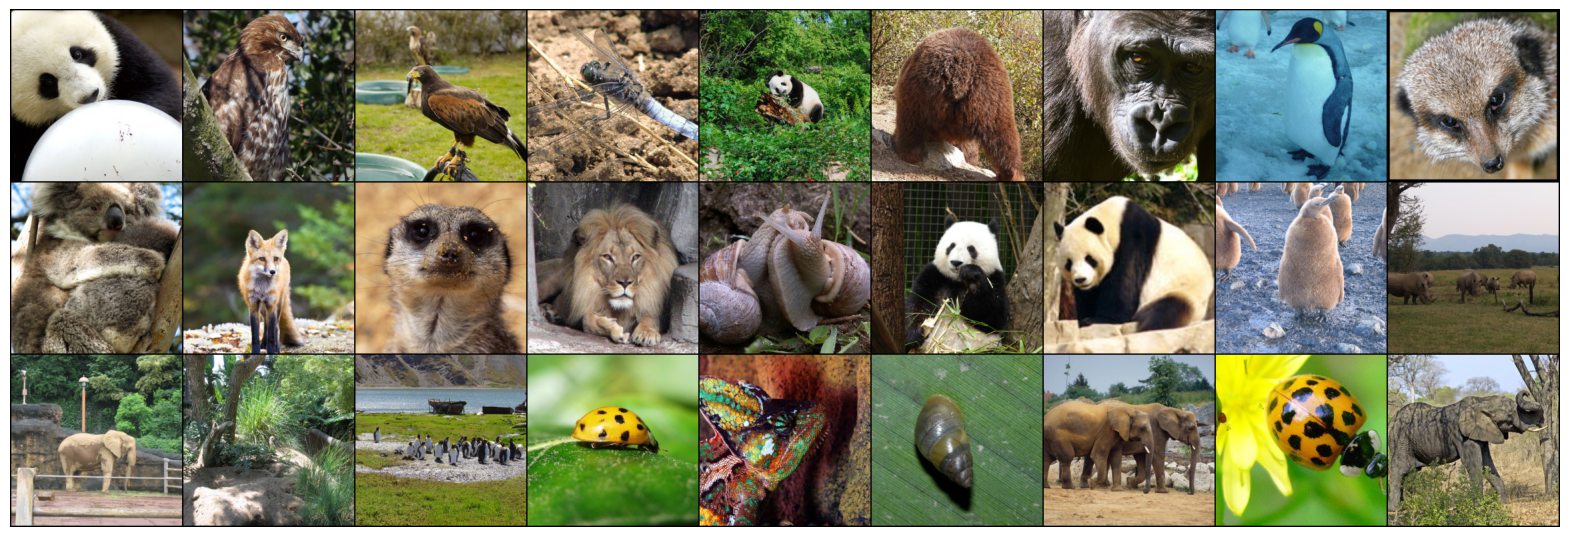

In [18]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [19]:
# Batch Norm After Addition
class ResidualBlock1(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock1, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False))

        self.shortcut = nn.Sequential()
        self.bn = nn.BatchNorm2d(outchannel)

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out += self.shortcut(x)

        out = self.bn(out)

        out = F.relu(out)

        return out



In [20]:
# Relu Last

class ResidualBlock2(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock2, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU())

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out = out + self.shortcut(x)


        return out


In [21]:
# Relu Last

class ResidualBlock2_leaky(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock2_leaky, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ELU(),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ELU())

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out = out + self.shortcut(x)


        return out


In [22]:
# Batch Norm Last
class ResidualBlock3(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock3, self).__init__()

        self.left = nn.Sequential(nn.ReLU(inplace=False),
                                  Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=False),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

       out = self.left(x)
       out = out + self.shortcut(x)
       return out


In [23]:
# Pre-Activation

class ResidualBlock4(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock4, self).__init__()

        self.left = nn.Sequential(nn.BatchNorm2d(inchannel),
                                  nn.ReLU(inplace=False),
                                  Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=False),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False))



        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)


        return out




In [24]:
class ResNet18(nn.Module):

    def __init__(self, ResidualBlock, num_classes = 20):

        super(ResNet18, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 2,
                                            padding = 3, bias = False),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())

        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)

        self.maxpool = MaxPool2d(33)
        self.avgpool = nn.AvgPool2d(17, stride=1)
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:

            layers.append(block(self.inchannel, channels, stride))

            self.inchannel = channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)
        # print("last")
        # print(x.shape)
        # print(x.shape)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [25]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(),
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out)
        
        return out


    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 16
        self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(16), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)


        self.maxpool = MaxPool2d(4)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        # x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)


def MyResNet18():
    return ResNet18(ResidualBlock2)

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None,
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [27]:
from sklearn.metrics import precision_score

USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)


print_every = 100
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set

    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          #print(precision_score(stack_labels.cpu(), stack_predicts.cpu(), average='macro'))
          confusion(stack_predicts, stack_labels)

          incorrect_preds(preds, y, x)
        return float(acc)



def train_part(model, optimizer, scheduler, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    loss_train = []
    best_val_acc = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        loss_epoch = []
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            #loss = F.cross_entropy(scores, y, weight= torch.tensor(weight).cuda())
            loss = F.cross_entropy(scores, y)
            # test
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()
            loss_epoch.append(loss.item())
            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
            scheduler.step()
        loss_train.append(np.mean(loss_epoch))
        
        val_acc = check_accuracy(loader_val, model)
        
        if val_acc > best_val_acc:
          best_val_acc = val_acc
          torch.save(model.state_dict(), 'best_model.pth')
          print('best model saved')
        
    x=np.arange(epochs)
    plt.plot(x,np.array(loss_train),'r--',label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    print('best val acc', best_val_acc)
    return best_val_acc

cuda:0


In [28]:
import random
param_grid = {
    'learning_rate':[0.01, 0.005, 0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128, 256, 512]
}

def train_part_random(param_grid, max_evals = 10, epochs = 20):
    best_score = 0
    best_val_acc = 0
    best_hyperparams = {}
    for i in range(max_evals):
        random.seed(i)	
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        print(hyperparameters)
        learning_rate = hyperparameters['learning_rate']
        batch_size = hyperparameters['batch_size']
        loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
        loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
        loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        model = MyResNet18()
        optimizer = optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=1e-7)
        #lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 15], gamma=0.5, last_epoch=-1)
        loss_train = []
        best_val_acc = 0
        model = model.to(device=device)  # move the model parameters to CPU/GPU
        for e in range(epochs):
            loss_epoch = []
            for t, (x, y) in enumerate(loader_train):
                model.train()  # put model to training mode
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=torch.long)

                scores = model(x)
                loss = F.cross_entropy(scores, y)

                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                optimizer.zero_grad()

                loss.backward()

                # Update the parameters of the model using the gradients
                optimizer.step()
                loss_epoch.append(loss.item())
                if t % print_every == 0:
                    print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #lr_scheduler.step()
            loss_train.append(np.mean(loss_epoch))

            val_acc = check_accuracy(loader_val, model)

            if val_acc > best_val_acc:
                best_val_acc = val_acc

                if val_acc > best_score:
                    torch.save(model.state_dict(), 'best_model.pth')
                    print('best model saved')

        if best_val_acc >  best_score:
            best_score = best_val_acc
            best_hyperparams = hyperparameters
        '''
        x=np.arange(epochs)
        plt.plot(x,np.array(loss_train),'r--',label='loss_train')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        '''
    print('best val acc', best_score)
    print('best hyperparams', best_hyperparams)

    return best_hyperparams



In [34]:
best_hyperparams = train_part_random(param_grid,  max_evals = 10, epochs = 20)

{'learning_rate': 0.0005, 'batch_size': 256}
Epoch: 0, Iteration 0, loss = 3.1925
Epoch: 0, Iteration 10, loss = 2.4623
Epoch: 0, Iteration 20, loss = 2.3915
Epoch: 0, Iteration 30, loss = 2.2911
Epoch: 0, Iteration 40, loss = 2.2512
Epoch: 0, Iteration 50, loss = 2.1780
Epoch: 0, Iteration 60, loss = 2.0639
Epoch: 0, Iteration 70, loss = 1.9960
Got 669 / 1998 correct of val set (33.48)
best model saved
Epoch: 1, Iteration 0, loss = 1.9965
Epoch: 1, Iteration 10, loss = 1.9525
Epoch: 1, Iteration 20, loss = 1.8981
Epoch: 1, Iteration 30, loss = 1.9424
Epoch: 1, Iteration 40, loss = 2.0331
Epoch: 1, Iteration 50, loss = 1.7279
Epoch: 1, Iteration 60, loss = 1.7657
Epoch: 1, Iteration 70, loss = 2.0597
Got 833 / 1998 correct of val set (41.69)
best model saved
Epoch: 2, Iteration 0, loss = 1.6984
Epoch: 2, Iteration 10, loss = 1.6713
Epoch: 2, Iteration 20, loss = 1.5891
Epoch: 2, Iteration 30, loss = 1.6680
Epoch: 2, Iteration 40, loss = 1.5895
Epoch: 2, Iteration 50, loss = 1.5575
Epoc

In [29]:
! pip install colorama==0.4.4
! pip install bayesian-optimization==1.4.0

In [34]:

from bayes_opt import BayesianOptimization
batch_size = 128
loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
def train_part_bayesian(lr, weight_decay):
    # define and train the network
    model = MyResNet18()
    optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
    epochs = 20
    loss_train = []
    best_val_acc = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        loss_epoch = []
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()
            loss_epoch.append(loss.item())
            if t % print_every == 0:
                #print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                ...
            #lr_scheduler.step()
        loss_train.append(np.mean(loss_epoch))

        val_acc = check_accuracy(loader_val, model)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            #print('best model saved')

    model = MyResNet18().cuda()
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    acc = check_accuracy(loader_val, model, analysis=False)
    return acc

gbdt_op = BayesianOptimization(
        train_part_bayesian,
        {'lr': (0.0005, 0.0015),
        'weight_decay': (1e-10, 1e-6)
        }
    )
gbdt_op.maximize(
    n_iter=10,
)
best = gbdt_op.max
print(best)

|   iter    |  target   |    lr     | weight... |
-------------------------------------------------
| 1         | 0.7938    | 0.001219  | 3.995e-07 |
| 2         | 0.7613    | 0.0005909 | 1.773e-07 |
| 3         | 0.7808    | 0.0005475 | 9.523e-07 |
| 4         | 0.7893    | 0.0008137 | 3.008e-07 |
| 5         | 0.7913    | 0.000652  | 8.788e-07 |
| 6         | 0.8108    | 0.001241  | 5.359e-07 |
| 7         | 0.7472    | 0.001263  | 5.438e-07 |
| 8         | 0.7773    | 0.001232  | 8.844e-07 |
| 9         | 0.7608    | 0.001205  | 1e-10     |
| 10        | 0.8133    | 0.001247  | 1.63e-08  |
| 11        | 0.7968    | 0.0006709 | 9.405e-07 |
| 12        | 0.7848    | 0.0006875 | 4.478e-07 |
| 13        | 0.7878    | 0.0007921 | 6.49e-07  |
| 14        | 0.7973    | 0.0008358 | 8.254e-07 |
| 15        | 0.7548    | 0.0008517 | 2.912e-07 |
{'target': 0.8133133133133134, 'params': {'lr': 0.001246684393916625, 'weight_decay': 1.6302141807435015e-08}}


Total number of parameters is: 2784468
Epoch: 0, Iteration 0, loss = 2.9912
Epoch: 0, Iteration 100, loss = 2.6949
Epoch: 0, Iteration 200, loss = 2.3729
Epoch: 0, Iteration 300, loss = 2.5215
Epoch: 0, Iteration 400, loss = 2.7022
Epoch: 0, Iteration 500, loss = 2.3756
Got 611 / 1998 correct of val set (30.58)
best model saved
Epoch: 1, Iteration 0, loss = 2.3642
Epoch: 1, Iteration 100, loss = 2.1072
Epoch: 1, Iteration 200, loss = 1.8733
Epoch: 1, Iteration 300, loss = 2.1606
Epoch: 1, Iteration 400, loss = 2.0158
Epoch: 1, Iteration 500, loss = 2.0498
Got 707 / 1998 correct of val set (35.39)
best model saved
Epoch: 2, Iteration 0, loss = 1.9475
Epoch: 2, Iteration 100, loss = 1.6509
Epoch: 2, Iteration 200, loss = 1.6466
Epoch: 2, Iteration 300, loss = 2.2096
Epoch: 2, Iteration 400, loss = 2.0463
Epoch: 2, Iteration 500, loss = 1.5118
Got 915 / 1998 correct of val set (45.80)
best model saved
Epoch: 3, Iteration 0, loss = 1.8818
Epoch: 3, Iteration 100, loss = 1.7293
Epoch: 3, It

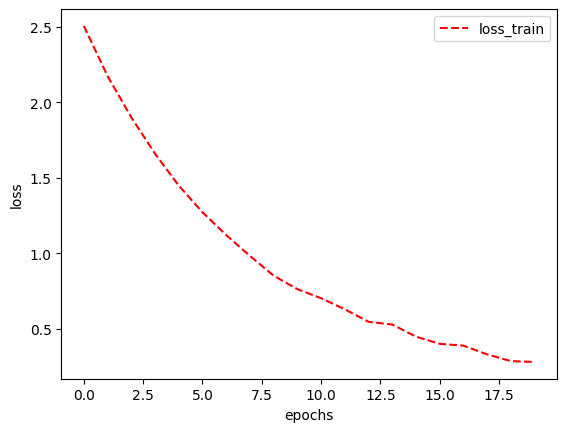

best val acc 0.8368368368368369
Got 1672 / 1998 correct of val set (83.68)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


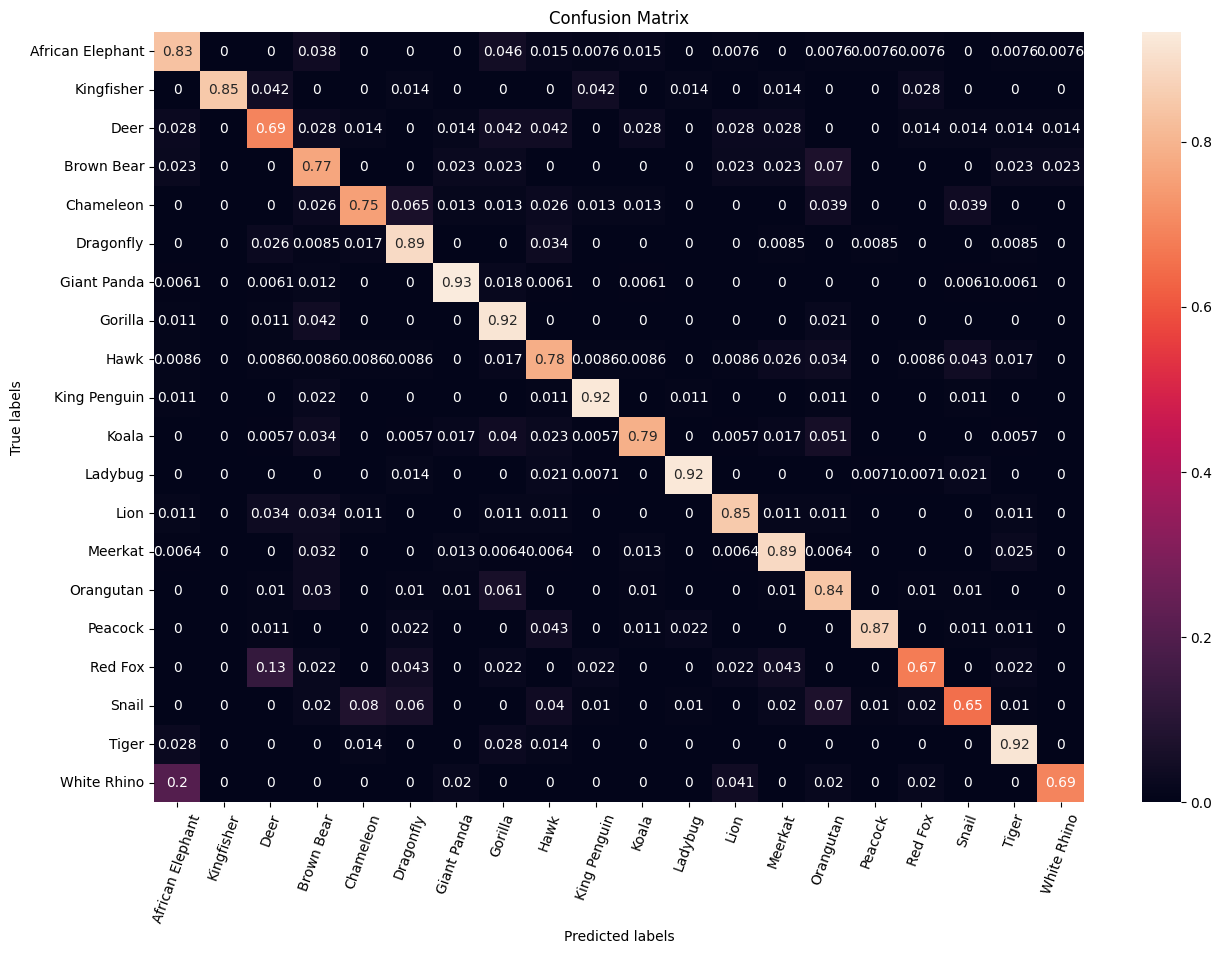

Predicted label ['Brown Bear' 'Chameleon' 'Hawk']
True label ['Gorilla' 'Snail' 'Peacock']
Corresponding images are shown below


0.8368368368368369

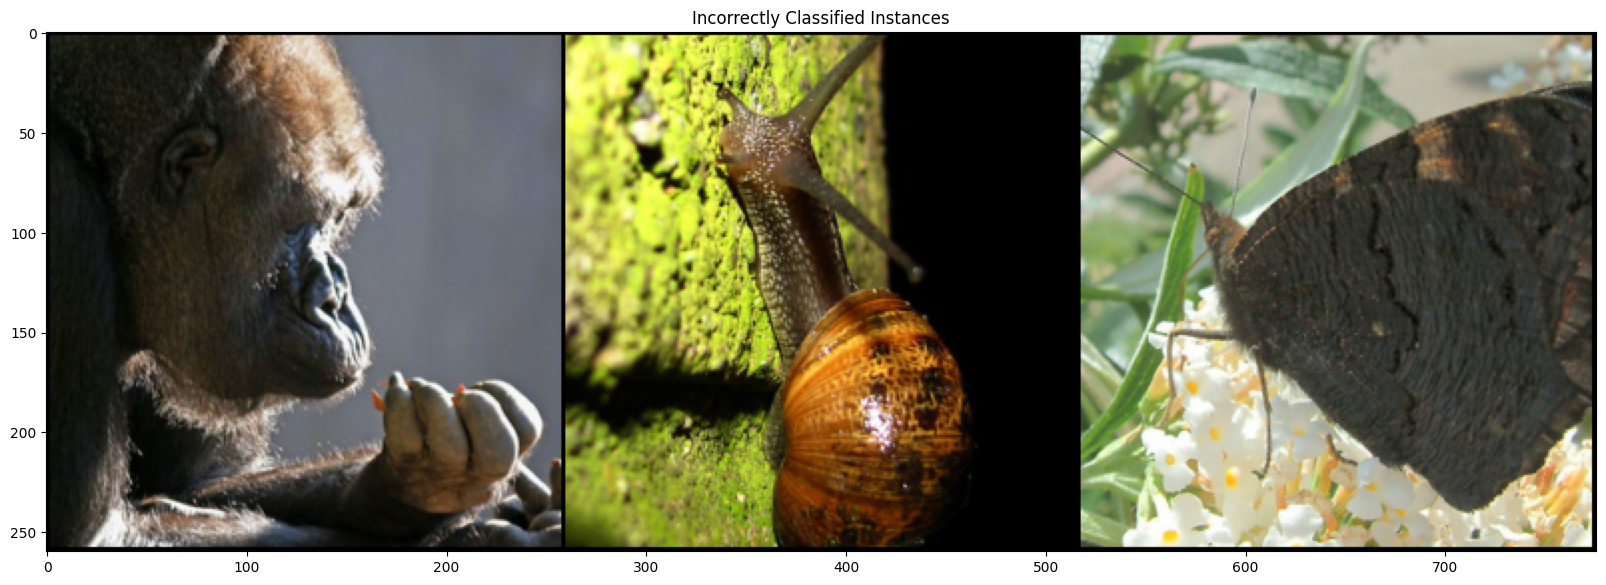

In [50]:
# define and train the network
model = MyResNet18()
optimizer = optim.Adamax(model.parameters(), lr=0.01, weight_decay=1e-7)


lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 15], gamma=0.8, last_epoch=-1)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, lr_scheduler, epochs =20)

model = MyResNet18().cuda()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model

# torch.save(model.state_dict(), 'baseline.pt') # correct of val set (0.3475)

# torch.save(model.state_dict(), 'baseline_avg.pt') # correct of val set (0.399)

# torch.save(model.state_dict(), 'model_lr001_batch_128.pt')  # correct of val set (0.556)


#torch.save(model.state_dict(), 'model_lr001_batch_128_18.pt')  # correct of val set (59.46)





<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1655 / 2000 correct of val set (82.75)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


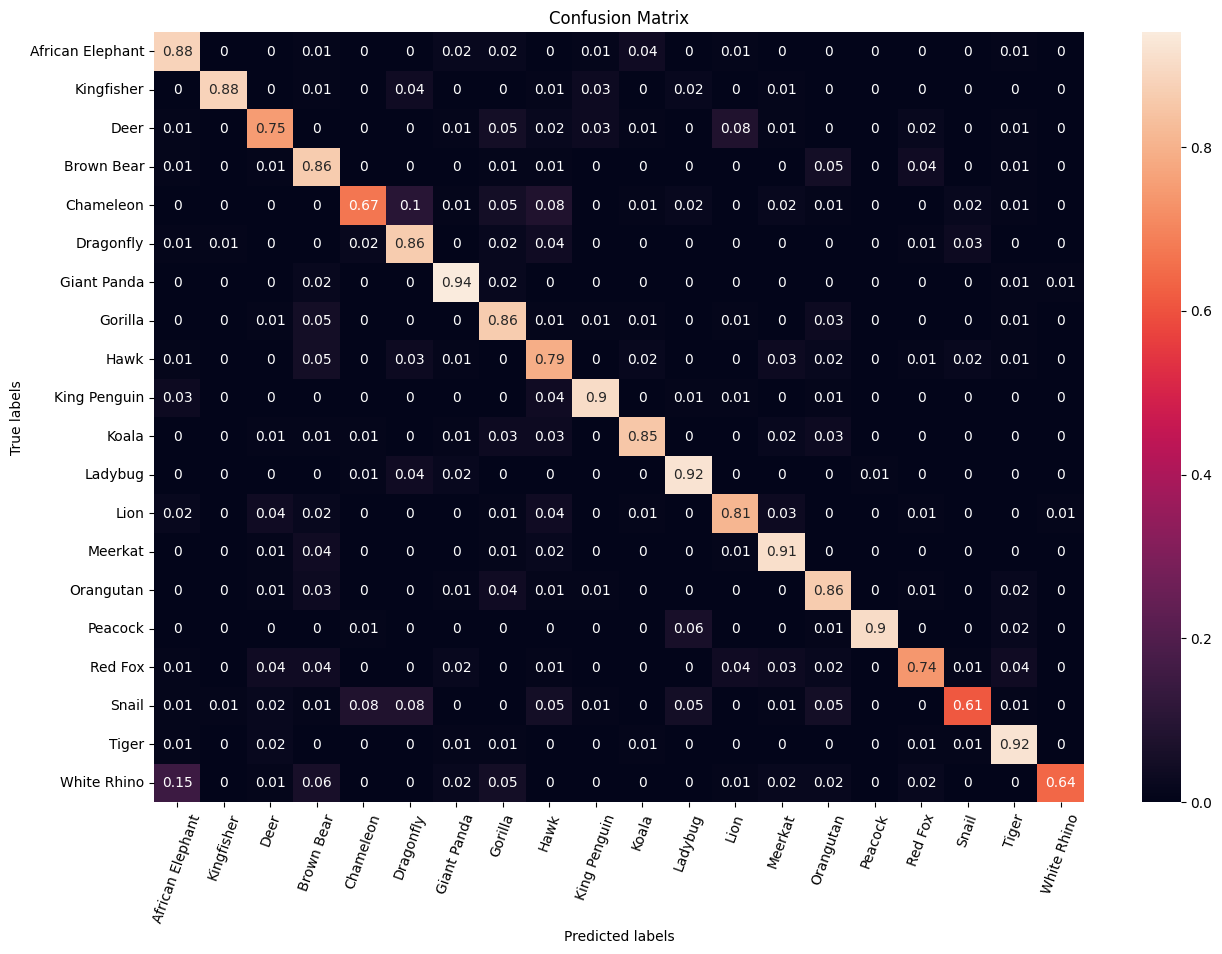

Predicted label ['Brown Bear' 'Deer']
True label ['Orangutan' 'Gorilla']
Corresponding images are shown below


0.8275

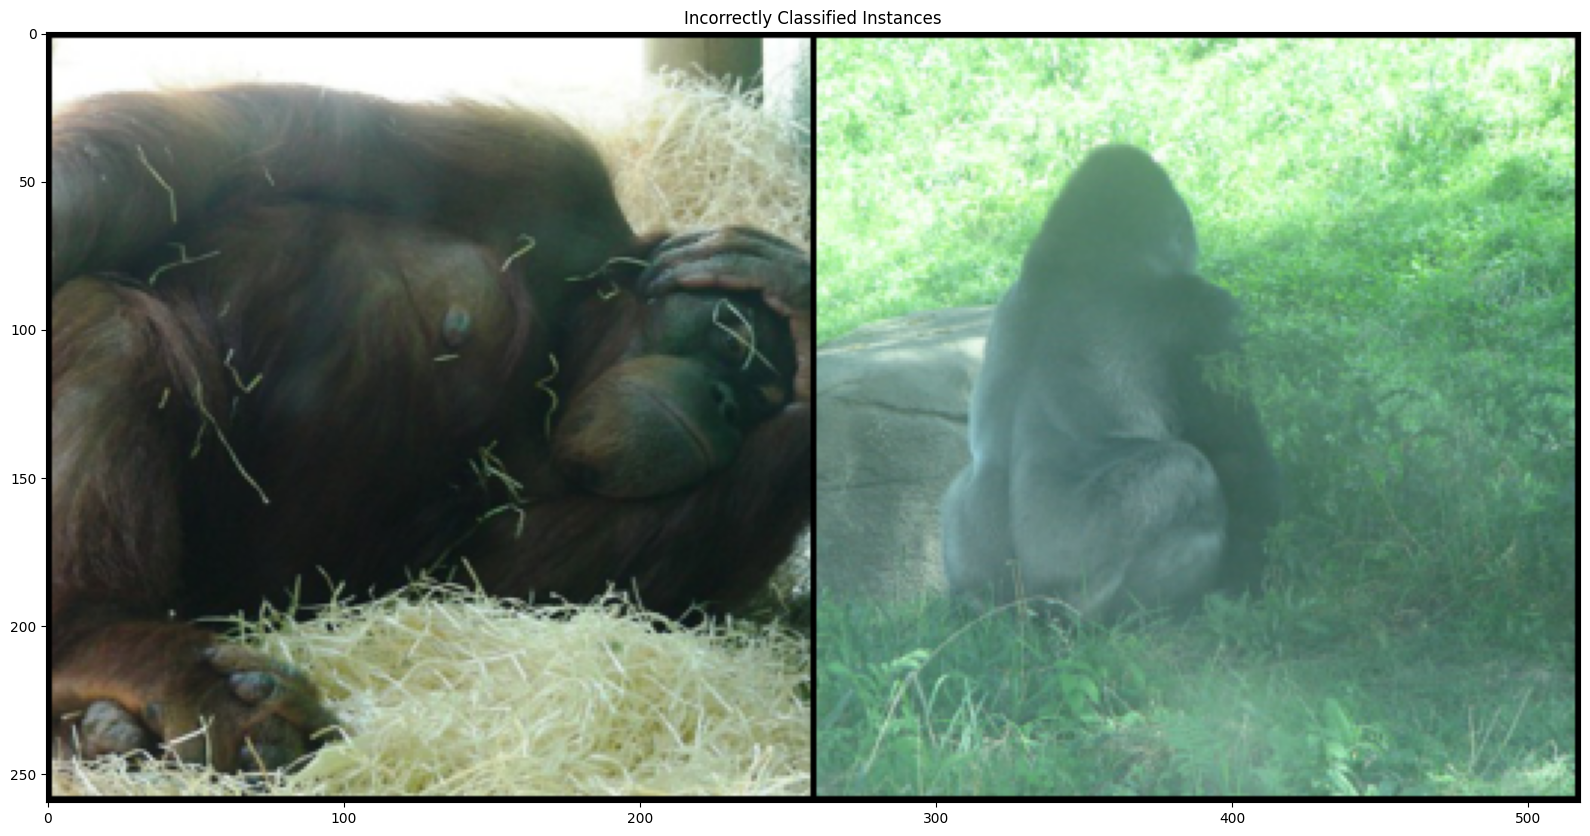

In [51]:
# Run once your have trained your final model
model = MyResNet18().cuda()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**
There are many hyperparameter search methods, such as grid search, random search, and Bayesian optimization. Given a large number of trainable parameters and the large number of data in the training set, I think Bayesian optimization is the best strategy for hyperparameter searching for the following reasons:

1.Grid search is not an ideal method because it is computationally expensive. Grid search trains models on every possible combination of hyperparameters. It can be infeasible when we have a large search space, large amounts of data and limited computational resources.

2.Random search is more efficient than grid search, since it does not try every combination of hyperparameters. But it is less likely to find the optimal hyperparameters due to the randomness.

3.Bayesian optimization outperforms the above methods. It is a probabilistic model that uses information learned from previous results to guide the search process. Bayesian optimization focuses on the most promising areas of the search space. This strategy is more efficient, which convergences faster to the optimal solution.


---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**


**1.Using global average pooling instead of global max pooling.**
The original model achieves 35.4% accuracy on the test set. After using the global average pooling, the accuracy achieves 40.1%, which imporves about 5%. The reason may be the global average pooling averages of all the values in the feature map, which represents all the features in the feature map and is more robust to noise. In contrast, global max pooling takes the max value and can be more sensitive to noise.

**2.Save the best model.**
As the performance of the models fluctuates on the validation set, the best performing model on the validation set is saved during the training process.

**3.Fine-tuning the model.**
After using global average pooling, accuracy on the validation set and test set is still very low. The loss on the training set is very low, which means the model overfits the training set. After fine-tuning the model, the accuracy achieves 74.9% on the test set in 20 epochs, with learning rate of 0.003 and batch size of 64. This result shows that the original model structure is not that bad. It is the unsuitable hyperparameters, which make the performance worse. Based on this result, I can further improve the performance by modifying the structure of the model.

**4.Reduce the complexity of the model.**
The original model has around 10 million parameters, which is much larger than the sample size. Since there are only 20 classes to classify and the differences between animal classes are obvious, the model can be simplified. Inspired by the ResNet18, I increased the number of filters in the first convolutional layer from 16 to 64, which can learn more different features. But I reduced the number of ResNet block layers and filters from  16, 32, 64, 128, 256, 512 to 64, 128, 256. Now the model has around 3 million parameters, which is much smaller than the original one. The accuracy achieves 76.75% in 20 epochs on the test set.

Actually, I tried different combinations of the number of layers and filters, the smallest of them has only one hundred thousand parameters, and the accuracy is still around 75%. But that model needs more epochs to reach high accuracy, which is inconvenient for conducting controlled experiments. So I chose the model with 3 million parameters.

The general idea is that ResNet has the property of learning the identity function, which means the performance of the model will not drop when the number of layers and filters is increased. So there must be the simplest model that can achieve high accuracy.

**5.Data augmentation.**
Data augmentation increases the diversity of the dataset, allowing the model to generalize better to different conditions. Since the photo can be taken in various lighting conditions, animals may have different poses and may be blocked. I used ColorJitter(brightness), RandomRotation() and RandomCrop(), respectively. RandomCrop() gets the best performance, which reaches 79.55% on the test set, which imporves about 3%. When I use all these methods together, model performance is worse than using any of these three methods. The reason may be that using too many data augmentations can create irrational images that confuse the model. Just like rotating a digit 9 will get a digit 6, using too much data augmentation may create some unexpected images and can be misleading while classifying animal images, so I chose only to use RandomCrop().

**6.Try different variants of ResNet block.**
There are different variance of ResNet blocks showns in the lecture slides and one of them may be suitable for this task. I tried Batch 'Norm After Addition', 'Relu Last', 'Batch Norm Last', 'Pre-Activation' respectivly and found that 'Relu Last' further impoved the performance of the model to 82.05%.

**7.Random search.**
To further improve the performance of the model, I used the random search to find the optimal hyperparameters. Random search is an efficient method in this task, since the model and the dataset are quite large. The search space is 'learning_rate':[0.01, 0.005, 0.001, 0.0005, 0.0001] and 'batch_size': [32, 64, 128, 256, 512]. After doing the random search, the optimal learning rate is 0.01, and the optimal batch size is 32.


**8.Learning rate decay.**
The model converged quickly in the first 10 epochs, but the accuracy on the validation set was very unstable as the training process went on, which means the learning rate was too large in this stage. To make the training result more stable, I used lr_scheduler to conduct learning rate decay and reduce the learning rate by 20% at epoch 10 and epoch 15. The model reaches 82.75% on the test set. Although the performance did not improve much, the training process became more stable.



**Some attempts without performance improvement**

**1.Try different activation function.**
I tried Leaky Relu, Elu and Selu respectively, among them Leaky Relu got the best performance which accuracy improved 2%. Theoretically, Leaky Rlu will have a better performance than Relu. When I used Leaky Relu without data augmentation, it worked better than using Relu. But after using data augmentation, there was no difference between Leaky Relu and Relu. It seems like there is a glass ceiling. Combining two methods does not guarantee better performance but instead reaches a bottleneck. So I gave up on trying different activation functions and instead continued to use Relu.

**2.Dealing with unbalanced dataset.**
I noticed that some classes have fewer samples and have relatively poor performance. So I used weighted cross_entropy and WeightedRandomSampler to balance these minority categories. However the accuracy is still around 81%. There are some improvements in the minority classes, but other classes are down-weighted and have slightly worse performance. So, the overall performance did not improve.

**3.Bayesian Optimization.**
After trying the random search, I used Bayesian optimization to fine-tune the model. I found that Bayesian optimization would be unstable if the search space of the hyper-parameters was too large. So I set the batch size to 128 and fine-tuned the learning rate and the weight decay. The result shows that the model's accuracy is still around 82%. So I chose to use the parameters found by random search.



<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(:

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**
Firstly, we can still recognize the original inputs in the low-level layer feature maps but can not do so in high-level layer. Features learned from the inputs are low-level local features, such as edge, point, corner and texture, which is easy to understand. For the high-level layer, the receptive field is larger and feature maps can better captures the overall information of the image, which are essential for the classification task. The high-level feature maps are more abstract and complex, which are not readable to humans.

Secondly, the differences between feature maps become more significant as the layer goes deeper. Since the convolutional kernels are randomly initialised and are updated during the training process, they will tend to focus on different features. The convolutional kernels are stacked layer by layer, so differences between feature maps are gradually magnified when the level of layer becomes higher.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**
The loss on the training set is constantly decreasing and converging to a relatively low value as shown in the chart above, which means that the model can learn the feature in the training set and fit it quite well. The accuracy on the test set is 82.75%. Given 20 classes, I think this result is sufficiently good. According to the feature map, this model can learn local features like edges and textures in low-level layers and more abstract features on high-level layers, indicating that the model is a powerful feature extractor.

However, the model performs relatively poor while classifying chameleon, snail and white rhino, which may need some imporvement in the future.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

In the above experiments, we used accuracy as an evaluation metric for the model. Although the model achieves high accuracy, this does not necessarily means that the model performs well. We should look at the model's performance in each class since the model may perform well in some classes but poorly in others. The inconsistent performance means our model needs more improvement or the data set is unbalanced.

From the confusion matrix, we can observe that the model performs differently in each class. To better understand the performance, we should calculate precision, recall and F1 score for each class based on the confusion matrix. In addition, we can also use the Micro-F1 and Macro-F1 to evaluate the model's overall performance.

Besides, we can draw the Receiver operating characteristic curve and calculate AUC to evaluate the performance of the model.

Also, we can build other strong baseline models to evaluate whether our model out performane them.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [52]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 640x480 with 0 Axes>

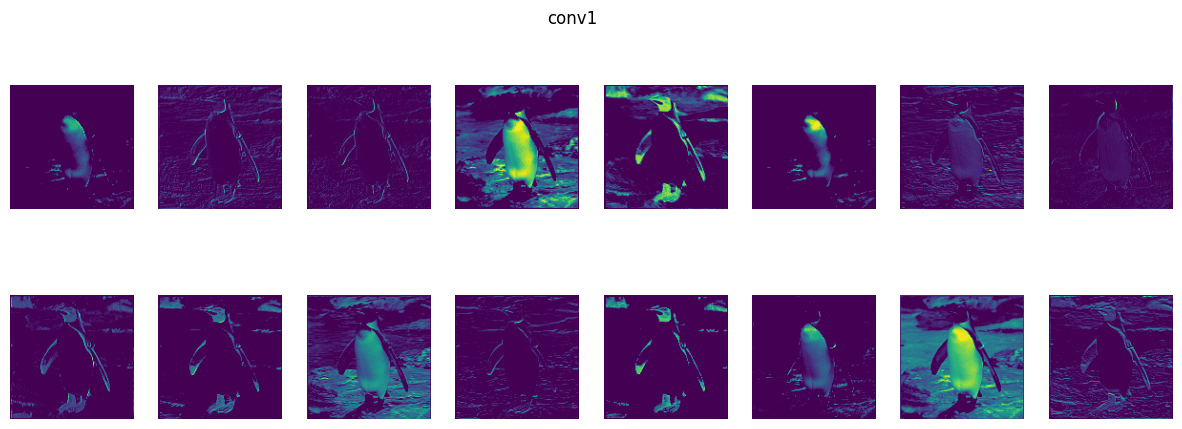

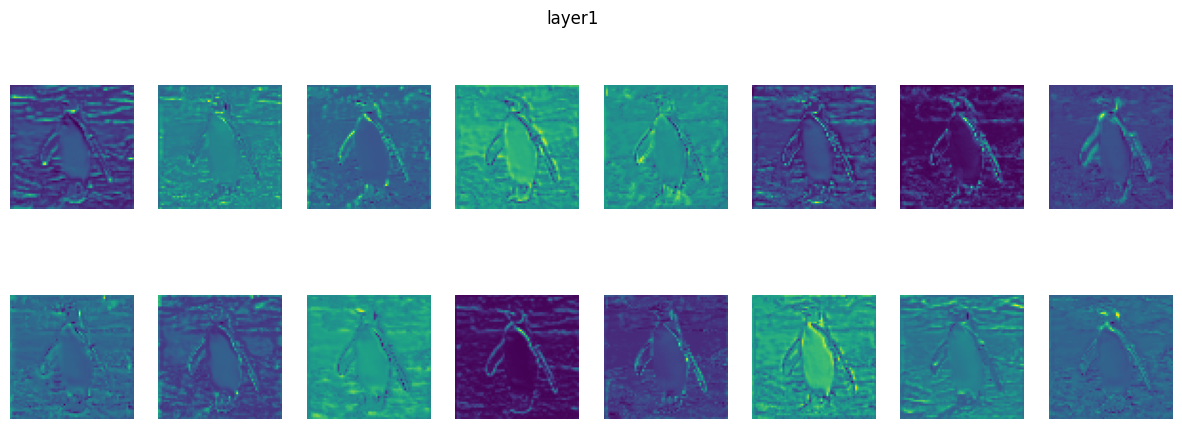

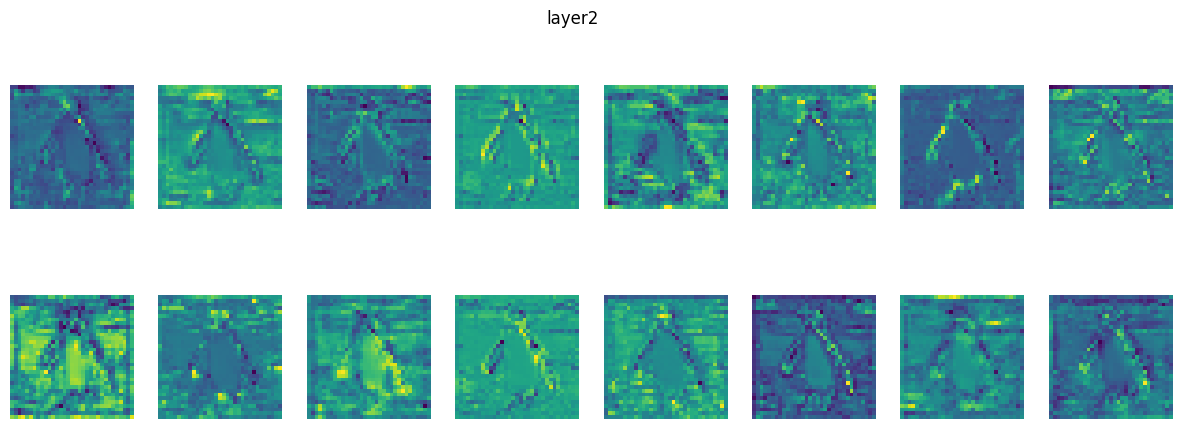

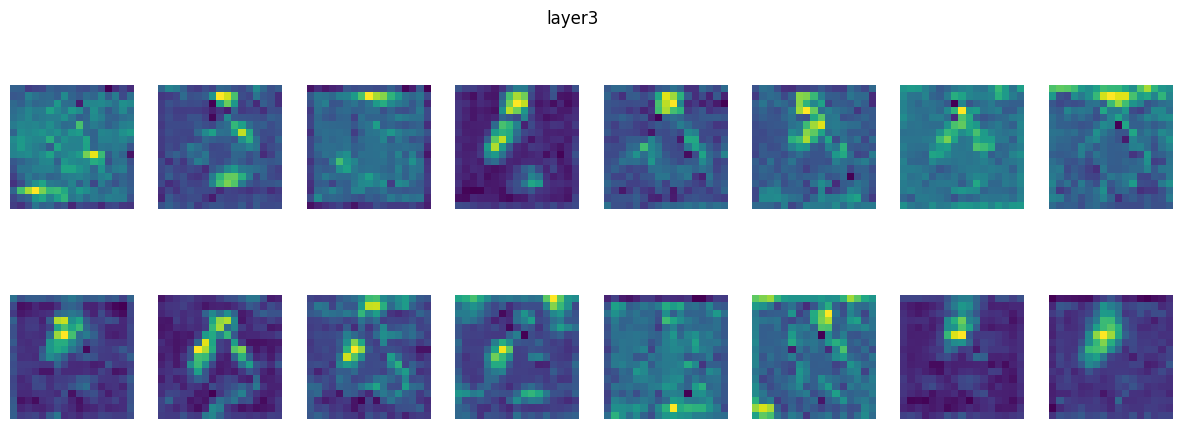

In [53]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
#grader.check_all()